# Proyecto Spotify Song Predictor
### Aprendizaje Automático, Universidad Complutense de Madrid


- **Eladia Gómez Morales**
- **Ana Martínez Sabiote**

## 1. Presentación del dataset

El siguiente proyecto trata de clasificar si le gustan o no canciones al que ha hecho el dataset, de acuerdo a sus características musicales y auditivas.
Dataset: https://www.kaggle.com/datasets/geomack/spotifyclassification

In [1351]:
from pandas.io.parsers import read_csv
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score,confusion_matrix,auc,roc_curve
from sklearn.svm import SVC
from time import time

In [1352]:
datos = pd.read_csv('data.csv')

Primero, revisamos como es el dataFrame del dataset de spotify, procedente de kaggle, que hemos cargado en nuestro notebook. Para ello, utilizamos la funcion head() de pandas, la cual devuelve las primeras n filas (5 por defecto) de dataFrame. De esta manera revisamos que tiene el tipo adecuado y podemos reflexionar sobre el preprocesamiento que debemos realizar a estos datos.

In [1353]:
datos.head()

,Unnamed: 0,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future
1,1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino
2,2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future
3,3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House
4,4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys


In [1354]:
print(datos.shape)

(2017, 17)


In [1355]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2017 entries, 0 to 2016
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        2017 non-null   int64  
 1   acousticness      2017 non-null   float64
 2   danceability      2017 non-null   float64
 3   duration_ms       2017 non-null   int64  
 4   energy            2017 non-null   float64
 5   instrumentalness  2017 non-null   float64
 6   key               2017 non-null   int64  
 7   liveness          2017 non-null   float64
 8   loudness          2017 non-null   float64
 9   mode              2017 non-null   int64  
 10  speechiness       2017 non-null   float64
 11  tempo             2017 non-null   float64
 12  time_signature    2017 non-null   float64
 13  valence           2017 non-null   float64
 14  target            2017 non-null   int64  
 15  song_title        2017 non-null   object 
 16  artist            2017 non-null   object 


## 2. Preprocesamiento de datos

Nuestro dataset tiene 2017 filas y 17 columnas. Lo primero que tenemos que hacer es comprender y familiarizarnos con nuestro dataset para entrar en el dominio del problema.

- Observamos que la columna "target", llamada generalmente label en el transcurso de este curso, toma valores 0 y 1. Hemos inspeccionado el dataset y hemos observado que las primeras 1021 filas corresponden al label 1 y las sucesivas al label 0. Es necesario ordenar aleatoriamente las filas del dataset.
- Vamos a cambiar las unidades de la columna 'duration_ms' de milisegundos a minutos y vamos a cambiar el nombre de dicha columna para que sea representativo ("duration_min")
- Vamos a eliminar la primera columna (unnamed, que ordena los datos del dataset), la penúltima columna - 16, ("song_title", es decir, título de la canción) y la última columna - 17 ("artist", cantante o grupo de dicha canción). Hemos decidido eliminar estas columnas ya que no vamos a usar estos datos para realizar la clasificación, ya que no ayudan. Preferimos tener variables categóricas (se decía así??)
- Comprobamos si hay valores nulos para eliminarlos y vemos que no los hay (como dice la info).

In [1356]:
pd.DataFrame(datos.isnull().sum(),columns=['null'])

,null
Unnamed: 0,0
acousticness,0
danceability,0
duration_ms,0
energy,0
instrumentalness,0
key,0
liveness,0
loudness,0
mode,0


In [1357]:
# Transformamos duration_ms a duration_min
datos["duration_ms"] = (1/60000) * datos["duration_ms"]
datos = datos.rename(columns={'duration_ms': 'duration_min'})

# Eliminamos la columna 0, 16 y 17.
datos=datos.iloc[:,1:15]

# Ordenamos aleatoriamente las filas del dataset
datos = datos.sample(frac=1)

In [1358]:
datos.head()

,acousticness,danceability,duration_min,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target
1333,0.000111,0.450,4.450000,0.986,0.25100,1,0.0645,-2.384,1,0.1510,159.976,4.0,0.172,0
1763,0.243000,0.652,4.914450,0.473,0.00000,0,0.1340,-7.981,0,0.0313,123.208,4.0,0.360,0
946,0.028000,0.658,1.817183,0.568,0.00356,1,0.1050,-7.579,1,0.0312,128.638,4.0,0.881,1
448,0.000910,0.516,4.183517,0.660,0.00000,9,0.0663,-5.002,0,0.0489,112.065,4.0,0.238,1
1500,0.091300,0.769,3.399867,0.631,0.00000,1,0.1140,-6.769,1,0.0568,100.968,4.0,0.501,0


In [1359]:
print(datos.shape)

(2017, 14)


In [1360]:
datos.describe()

,acousticness,danceability,duration_min,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target
count,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000
mean,0.187590,0.618422,4.105103,0.681577,0.133286,5.342588,0.190844,-7.085624,0.612295,0.092664,121.603272,3.968270,0.496815,0.505702
std,0.259989,0.161029,1.366364,0.210273,0.273162,3.648240,0.155453,3.761684,0.487347,0.089931,26.685604,0.255853,0.247195,0.500091
min,0.000003,0.122000,0.267367,0.014800,0.000000,0.000000,0.018800,-33.097000,0.000000,0.023100,47.859000,1.000000,0.034800,0.000000
25%,0.009630,0.514000,3.333583,0.563000,0.000000,2.000000,0.092300,-8.394000,0.000000,0.037500,100.189000,4.000000,0.295000,0.000000
50%,0.063300,0.631000,3.821017,0.715000,0.000076,6.000000,0.127000,-6.248000,1.000000,0.054900,121.427000,4.000000,0.492000,1.000000
75%,0.265000,0.738000,4.505550,0.846000,0.054000,9.000000,0.247000,-4.746000,1.000000,0.108000,137.849000,4.000000,0.691000,1.000000
max,0.995000,0.984000,16.743783,0.998000,0.976000,11.000000,0.969000,-0.307000,1.000000,0.816000,219.331000,5.000000,0.992000,1.000000


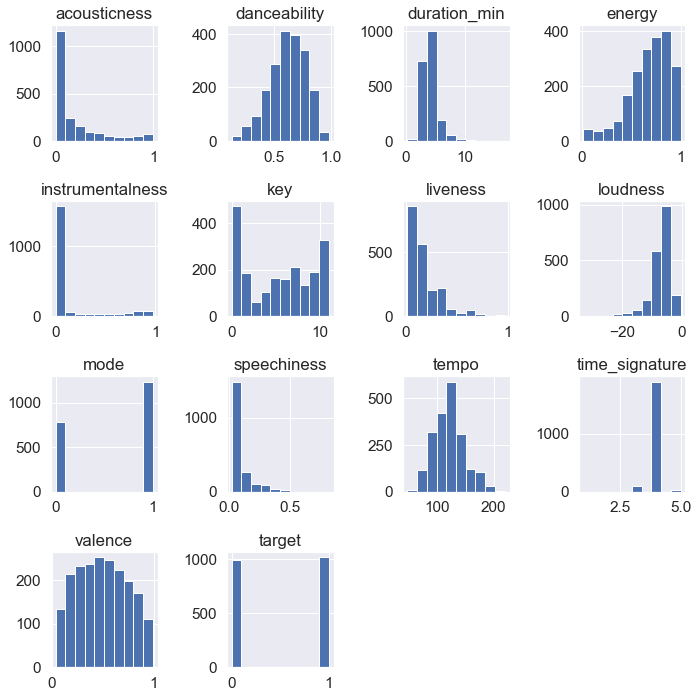

In [1361]:
datos.hist(figsize=(10, 10)) 
plt.tight_layout()

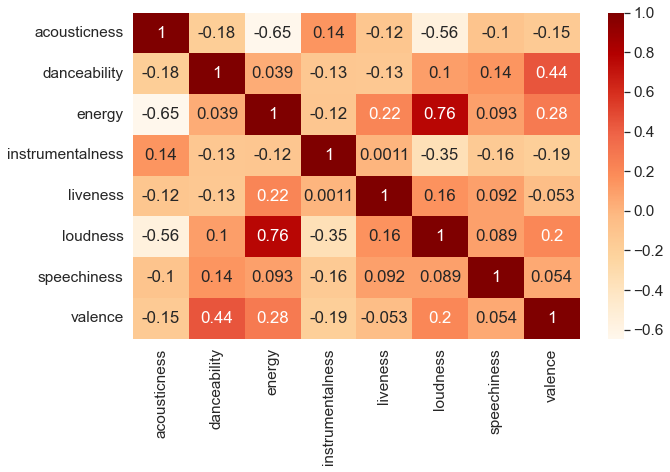

In [1362]:
#Correlación
data_numerical=datos[['acousticness','danceability','energy','instrumentalness','liveness','loudness','speechiness','valence']]
plt.figure(figsize=(10,6))
sns.heatmap(data_numerical.corr(),annot=True,cmap='OrRd')
plt.show()

In [1363]:
# Normalización
ss = preprocessing.StandardScaler()
scale_features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'valence']
datos[scale_features]=ss.fit_transform(datos[scale_features])


In [1364]:
datos.head()

,acousticness,danceability,duration_min,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target
1333,-0.721282,-1.046170,4.450000,1.448110,0.431039,1,-0.812948,1.250182,1,0.648830,159.976,4.0,-1.314327,0
1763,0.213177,0.208574,4.914450,-0.992181,-0.488057,0,-0.365757,-0.238084,0,-0.682514,123.208,4.0,-0.553606,0
946,-0.613985,0.245843,1.817183,-0.540275,-0.475021,1,-0.552355,-0.131191,1,-0.683626,128.638,4.0,1.554560,1
448,-0.718208,-0.636204,4.183517,-0.102640,-0.488057,9,-0.801366,0.554045,0,-0.486761,112.065,4.0,-1.047265,1
1500,-0.370453,0.935331,3.399867,-0.240590,-0.488057,1,-0.494445,0.084192,1,-0.398894,100.968,4.0,0.016934,0


In [1365]:
datos.describe()

,acousticness,danceability,duration_min,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target
count,2.017000e+03,2.017000e+03,2017.000000,2.017000e+03,2.017000e+03,2017.000000,2.017000e+03,2.017000e+03,2017.000000,2.017000e+03,2017.000000,2017.000000,2.017000e+03,2017.000000
mean,3.423692e-17,4.434287e-16,4.105103,-5.708333e-16,1.816428e-18,5.342588,-9.205989e-17,-1.941101e-16,0.612295,6.533638e-17,121.603272,3.968270,-1.265927e-16,0.505702
std,1.000248e+00,1.000248e+00,1.366364,1.000248e+00,1.000248e+00,3.648240,1.000248e+00,1.000248e+00,0.487347,1.000248e+00,26.685604,0.255853,1.000248e+00,0.500091
min,-7.216979e-01,-3.083576e+00,0.267367,-3.171793e+00,-4.880565e-01,0.000000,-1.107000e+00,-6.916536e+00,0.000000,-7.737170e-01,47.859000,1.000000,-1.869491e+00,0.000000
25%,-6.846597e-01,-6.486275e-01,3.333583,-5.640598e-01,-4.880565e-01,2.000000,-6.340718e-01,-3.479027e-01,0.000000,-6.135554e-01,100.189000,4.000000,-8.166212e-01,0.000000
50%,-4.781769e-01,7.813008e-02,3.821017,1.589892e-01,-4.877775e-01,6.000000,-4.107981e-01,2.227279e-01,1.000000,-4.200267e-01,121.427000,4.000000,-1.948343e-02,1.000000
75%,2.978168e-01,7.427716e-01,4.505550,7.821433e-01,-2.903227e-01,9.000000,3.613301e-01,6.221161e-01,1.000000,1.705693e-01,137.849000,4.000000,7.857471e-01,1.000000
max,3.106321e+00,2.270826e+00,16.743783,1.505192e+00,3.085799e+00,11.000000,5.006968e+00,1.802465e+00,1.000000,8.045183e+00,219.331000,5.000000,2.003709e+00,1.000000


Arriba vemos que las columnas que hemos indicado que se normalicen tiene media 0 y varianza 1, como queríamos.

In [1366]:
#Bucketizacion duration_min
bins = np.arange(0.00, 17.00, 2.0) 
datos['duration_min'] = pd.cut(datos.duration_min, bins, labels=bins[:-1])

In [1367]:
#Bucketizacion tempo
bins = np.arange(46.00, 220.00, 25.0) 
datos['tempo'] = pd.cut(datos.tempo, bins, labels=bins[:-1])

In [1368]:
datos.describe()

,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,time_signature,valence,target
count,2.017000e+03,2.017000e+03,2.017000e+03,2.017000e+03,2017.000000,2.017000e+03,2.017000e+03,2017.000000,2.017000e+03,2017.000000,2.017000e+03,2017.000000
mean,3.423692e-17,4.434287e-16,-5.708333e-16,1.816428e-18,5.342588,-9.205989e-17,-1.941101e-16,0.612295,6.533638e-17,3.968270,-1.265927e-16,0.505702
std,1.000248e+00,1.000248e+00,1.000248e+00,1.000248e+00,3.648240,1.000248e+00,1.000248e+00,0.487347,1.000248e+00,0.255853,1.000248e+00,0.500091
min,-7.216979e-01,-3.083576e+00,-3.171793e+00,-4.880565e-01,0.000000,-1.107000e+00,-6.916536e+00,0.000000,-7.737170e-01,1.000000,-1.869491e+00,0.000000
25%,-6.846597e-01,-6.486275e-01,-5.640598e-01,-4.880565e-01,2.000000,-6.340718e-01,-3.479027e-01,0.000000,-6.135554e-01,4.000000,-8.166212e-01,0.000000
50%,-4.781769e-01,7.813008e-02,1.589892e-01,-4.877775e-01,6.000000,-4.107981e-01,2.227279e-01,1.000000,-4.200267e-01,4.000000,-1.948343e-02,1.000000
75%,2.978168e-01,7.427716e-01,7.821433e-01,-2.903227e-01,9.000000,3.613301e-01,6.221161e-01,1.000000,1.705693e-01,4.000000,7.857471e-01,1.000000
max,3.106321e+00,2.270826e+00,1.505192e+00,3.085799e+00,11.000000,5.006968e+00,1.802465e+00,1.000000,8.045183e+00,5.000000,2.003709e+00,1.000000


In [1369]:
datos['duration_min']

/Users/elagomezmorales/opt/anaconda3/lib/python3.9/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


1333    4.0
1763    4.0
946     0.0
448     4.0
1500    2.0
       ... 
1114    2.0
1427    2.0
670     4.0
666     4.0
1045    4.0
Name: duration_min, Length: 2017, dtype: category
Categories (8, float64): [0.0 < 2.0 < 4.0 < 6.0 < 8.0 < 10.0 < 12.0 < 14.0]

In [1370]:
datos['tempo']

1333    146.0
1763    121.0
946     121.0
448      96.0
1500     96.0
        ...  
1114     71.0
1427    121.0
670     121.0
666     121.0
1045    121.0
Name: tempo, Length: 2017, dtype: category
Categories (6, float64): [46.0 < 71.0 < 96.0 < 121.0 < 146.0 < 171.0]

In [1371]:
bucketized_features = ['duration_min', 'tempo']
datos_cat = pd.get_dummies(datos[bucketized_features])
datos = datos.drop(bucketized_features, axis=1)
datos = pd.concat([datos, datos_cat], axis=1)

In [1372]:
# Separamos el dataset en X y labels(y). Pasamos de pandas a numpy para seguir operando con arrays de numpy.
X = datos.iloc[:, 0:13].to_numpy()
y = datos.iloc[:, 13].to_numpy()

## 3. Dateset Final

In [1373]:
print(X.shape)
print(y.shape)

(2017, 13)
(2017,)


## 4. Separación en entrenamiento, validación y test

Dividimos el dataset en entrenamiento, validación y test. 

Hacemos una división en las siguientes partes:
- **60%** Entrenamiento (training set)
- **20%** Validación (validation set)
- **20%** test (test set)

In [1374]:
x, x_test, y, y_test = train_test_split(X,y,test_size=0.2,train_size=0.8)
x_train, x_val, y_train, y_val = train_test_split(x,y,test_size = 0.25,train_size =0.75)

In [1375]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(1209, 13)
(404, 13)
(404, 13)


## 4. Regresión logística

In [1376]:
from sklearn.preprocessing import PolynomialFeatures
import scipy.optimize as opt

### 4.1 Regresión logística lineal

In [1377]:
def sigmoide(z):
    return (1.0/(1.0+np.exp(-z)))

In [1378]:
def coste(Theta, X, y):
    H = sigmoide(np.dot(X, Theta))
    Term1 = np.matmul(y, np.log(H))
    Term2 = np.matmul((1 - y), np.log(1 - H))
    cost = (- 1 / (len(y))) * np.sum(Term1 + Term2)
    return cost

In [1379]:
def coste_reg(Theta, X, y, Lambda):
    Term1 = coste(Theta, X, y)
    Term2 = (Lambda/(2*len(y))) * np.sum(Theta**2)
    cost = Term1 + Term2
    return cost 

In [1380]:
def gradiente(Theta, X, y):
    H = sigmoide(np.dot(X, Theta))
    Dif = H - y
    grad = (1 / len(y)) * np.matmul(Dif, X)
    return grad

In [1381]:
def gradiente_reg(Theta, X, y, Lambda):
    grad = gradiente(Theta, X, y) + ((Lambda/len(y))*np.r_[[0],Theta[1:]])
    return grad

In [1382]:
def evaluacion(theta, X, Y):
    prediccion = sigmoide(np.matmul(theta, np.transpose(X)))
    prediccion[prediccion >= 0.5] = 1
    prediccion[prediccion < 0.5] = 0
    porcentaje = np.asarray(np.where(prediccion == Y)).size
    return  (porcentaje / len(Y))*100

In [1383]:
#Optimizacion de Theta con Lambda = 1
x_train_1 = np.hstack([np.ones([len(x_train), 1]), x_train])
Theta = np.zeros(x_train_1.shape[1])
Lambda = 1
result = opt.fmin_tnc(func=coste_reg, x0=Theta, fprime=gradiente_reg, args=(x_train_1,y_train,Lambda))
Theta_opt=result[0]
print(Theta_opt)
coste_opt = coste_reg(Theta_opt, x_train_1, y_train, Lambda)
print('Coste regularizado (entrenamiento) = {}'.format(coste_opt))
error = coste(Theta_opt, x_train_1, y_train)
print('Error - coste (entrenamiento) = {}'.format(error))

  NIT   NF   F                       GTG
    0    1  6.931471805599450E-01   2.46166919E-01
    1    6  6.300377070572454E-01   1.32734801E-03
tnc: fscale = 27.4478
    2   12  6.236357209716236E-01   3.24226231E-04


[-0.32651902  0.23200066 -0.0324669  -0.01786712 -0.25602535 -0.01684076
 -0.12021777  0.54712766  0.27282229  0.1145131   0.20885375  0.19019662
 -0.45882596 -2.42759207]
Coste regularizado (entrenamiento) = 0.6167194627538163
Error - coste (entrenamiento) = 0.6139020473966766


    3   16  6.169258857847073E-01   3.31947539E-05
    4   19  6.167589254233237E-01   1.69014283E-05
    5   23  6.167402012956060E-01   6.01906821E-06
    6   31  6.167300659722551E-01   1.97160278E-06
tnc: fscale = 712.181
    7   39  6.167199935252383E-01   1.13655183E-06
    8   47  6.167196946591005E-01   9.53528759E-06
    9   72  6.167194627538163E-01   5.59463088E-06
tnc: |fn-fn-1] = 0 -> convergence
   10  112  6.167194627538163E-01   5.59463088E-06
tnc: Converged (|f_n-f_(n-1)| ~= 0)


In [1384]:
porcentaje_aciertos_train = evaluacion(Theta_opt, x_train_1, y_train)
print("El porcentaje de ejemplos de entrenamientos que se clasifican correctamente es: {}%".format(porcentaje_aciertos_train))
x_val_1 = np.hstack([np.ones([len(x_val), 1]), x_val])
porcentaje_aciertos_val = evaluacion(Theta_opt, x_val_1, y_val)
print("El porcentaje de ejemplos de validacion que se clasifican correctamente es: {}%".format(porcentaje_aciertos_val))

El porcentaje de ejemplos de entrenamientos que se clasifican correctamente es: 66.58395368072787%
El porcentaje de ejemplos de validacion que se clasifican correctamente es: 69.80198019801979%


In [1385]:
lambdas = [150, 100, 50, 10, 1, 0.5, 0.25]
bestScore= -1
acc_train =[]
acc_val = []
tiempo_inicial = time()
for i in lambdas:
    result = opt.fmin_tnc(func=coste_reg, x0=Theta, fprime=gradiente_reg, args=(x_train_1,y_train,i))
    Theta_opt=result[0]
    porcentaje_aciertos_train = evaluacion(Theta_opt, x_train_1, y_train)
    acc_train.append(porcentaje_aciertos_train)
    porcentaje_aciertos_val = evaluacion(Theta_opt, x_val_1, y_val)
    acc_val.append(porcentaje_aciertos_val)
    if(porcentaje_aciertos_val > bestScore):
            bestScore = porcentaje_aciertos_val
            bestLambda = i
            bestThetaOpt = Theta_opt

    print("Lambda {} Train - {}%, Validation - {}%".format(i, porcentaje_aciertos_train,porcentaje_aciertos_val))
print("Best Lambda:{}, best porcentaje aciertos validacion:{}%".format(bestLambda, bestScore))

tiempo_final =  time()
tiempo_logistic_linear = tiempo_final - tiempo_inicial
print("Tiempo entrenamiento regresión logística lineal: {} segundos".format(tiempo_logistic_linear))

  NIT   NF   F                       GTG
    0    1  6.931471805599450E-01   2.46166919E-01
    1    5  6.485044382027975E-01   1.54002288E-03
tnc: fscale = 25.4822
    2    8  6.475060525776762E-01   4.63246299E-04
    3   12  6.468626704843823E-01   2.26103952E-05
    3   62  6.468626704843823E-01   2.26103952E-05
tnc: Linear search failed
  NIT   NF   F                       GTG
    0    1  6.931471805599450E-01   2.46166919E-01
    1    5  6.450144663032815E-01   2.00384771E-03
tnc: fscale = 22.3392
    2    8  6.435750288762907E-01   7.54890855E-04
    3   11  6.424100096593010E-01   1.01932684E-03
    4   15  6.423032432494360E-01   5.12872765E-06
    4   64  6.423032432494360E-01   5.12872765E-06
tnc: Linear search failed
  NIT   NF   F                       GTG
    0    1  6.931471805599450E-01   2.46166919E-01
    1    5  6.406627109834782E-01   2.67783249E-03
    2    9  6.361046915081446E-01   1.02282055E-03
tnc: fscale = 31.268
    3   15  6.357027401125205E-01   4.33116162

Lambda 150 Train - 64.51612903225806%, Validation - 67.07920792079209%
Lambda 100 Train - 65.01240694789082%, Validation - 68.31683168316832%
Lambda 50 Train - 65.01240694789082%, Validation - 68.06930693069307%
Lambda 10 Train - 65.83953680727875%, Validation - 70.04950495049505%


    4   66  6.356933780809623E-01   1.70802056E-06
tnc: Linear search failed
  NIT   NF   F                       GTG
    0    1  6.931471805599450E-01   2.46166919E-01
    1    6  6.316774465548088E-01   1.19908717E-03
tnc: fscale = 28.8785
    2   11  6.270179177817216E-01   1.06969809E-04
    3   15  6.255157577515583E-01   8.31373251E-05
    4   21  6.255013963933627E-01   4.87090966E-07
tnc: fscale = 1432.83
    5   28  6.255003817231607E-01   1.35900839E-08
    6   36  6.254946356640654E-01   8.05739840E-08
    7   41  6.254935709676139E-01   1.46702081E-08
    8   44  6.254935503888356E-01   6.54610564E-09
tnc: |fn-fn-1] = 9.08023e-09 -> convergence
    9   49  6.254935413086082E-01   7.33539514E-11
tnc: Converged (|f_n-f_(n-1)| ~= 0)
  NIT   NF   F                       GTG
    0    1  6.931471805599450E-01   2.46166919E-01
    1    6  6.300377070572454E-01   1.32734801E-03
tnc: fscale = 27.4478
    2   12  6.236357209716236E-01   3.24226231E-04
    3   16  6.169258857847073E-0

Lambda 1 Train - 66.58395368072787%, Validation - 69.80198019801979%
Lambda 0.5 Train - 66.91480562448304%, Validation - 69.80198019801979%
Lambda 0.25 Train - 66.74937965260546%, Validation - 69.80198019801979%
Best Lambda:10, best porcentaje aciertos validacion:70.04950495049505%
Tiempo entrenamiento regresión logística lineal: 0.39591503143310547 segundos


tnc: |fn-fn-1] = 9.5326e-17 -> convergence
   11  131  6.150538883258974E-01   5.41150172E-06
tnc: Converged (|f_n-f_(n-1)| ~= 0)
  NIT   NF   F                       GTG
    0    1  6.931471805599450E-01   2.46166919E-01
    1    6  6.298948870423170E-01   1.33858705E-03
tnc: fscale = 27.3323
    2   12  6.233395865360654E-01   3.37794172E-04
    3   16  6.146835341850870E-01   5.88525160E-05
    4   19  6.140564743130794E-01   5.27389911E-05
    5   23  6.139479740214330E-01   3.59847856E-05
    6   29  6.139319331642641E-01   1.17021616E-06
tnc: fscale = 924.415
    7   37  6.139102812830113E-01   5.83174682E-06
    8   45  6.138637147703545E-01   5.38222071E-05
    9   51  6.138568213855501E-01   1.45457272E-07
   10   72  6.138567879530721E-01   2.72005986E-08
tnc: |fn-fn-1] = 0 -> convergence
   11  104  6.138567879530721E-01   2.72005971E-08
tnc: Converged (|f_n-f_(n-1)| ~= 0)


In [1386]:
x_test_1 = np.hstack([np.ones([len(x_test), 1]), x_test])
acc_test_Logistic_Linear = evaluacion(bestThetaOpt, x_test_1, y_test)
print("El porcentaje de ejemplos de test que se clasifican correctamente es: {}%".format(acc_test_Logistic_Linear))

El porcentaje de ejemplos de test que se clasifican correctamente es: 63.11881188118812%


In [1387]:
def plot_results(vector_x, acc_train, acc_val, bestLambda, porcentaje_aciertos_test):
    plt.plot(vector_x, acc_train, label='Training')
    plt.plot(vector_x, acc_val, label='Validation')
    plt.scatter(bestLambda, porcentaje_aciertos_test, label= 'Accuracy test')

    plt.xlabel('Lambdas')
    plt.ylabel('Accuracy')
    plt.title('Regresión Logística')
    plt.legend(loc = 'best', bbox_to_anchor=(1,1))
    plt.show()

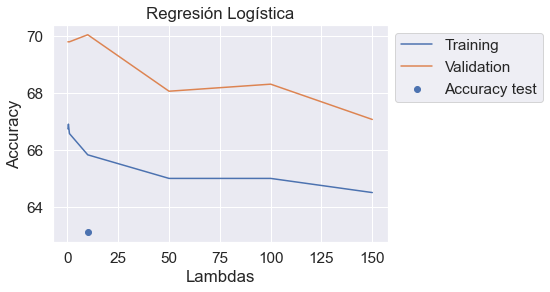

In [1388]:
plot_results(lambdas, acc_train, acc_val, bestLambda, acc_test_Logistic_Linear)

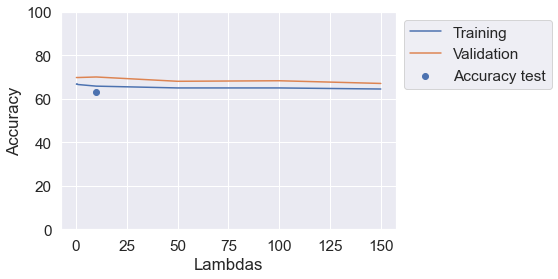

In [1389]:
plt.plot(lambdas, acc_train, label='Training')
plt.plot(lambdas, acc_val, label='Validation')
plt.scatter(bestLambda, acc_test_Logistic_Linear, label= 'Accuracy test')
plt.ylim(0, 100)

plt.xlabel('Lambdas')
plt.ylabel('Accuracy')
plt.legend(loc = 'best', bbox_to_anchor=(1,1))
plt.show()

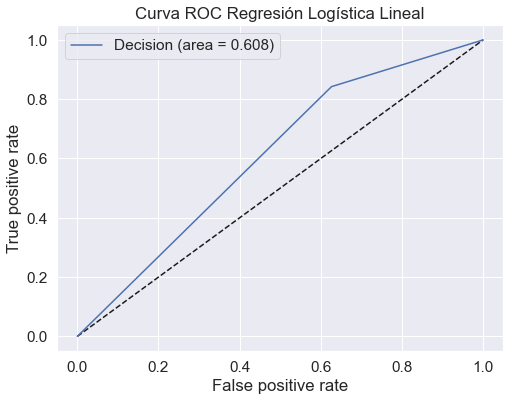

In [1390]:
y_pred= sigmoide(np.matmul(bestThetaOpt, np.transpose(x_test_1)))
y_pred[y_pred >= 0.5] = 1
y_pred[y_pred < 0.5] = 0


fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(figsize=(8,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Decision (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Curva ROC Regresión Logística Lineal')
plt.legend(loc='best')
plt.show()

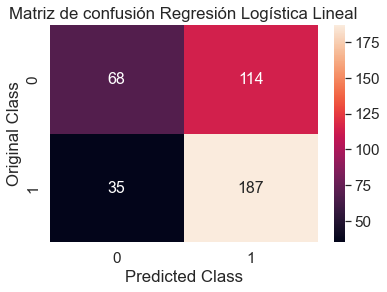

In [1391]:
plt.figure(figsize=(6,4))
df_ = pd.DataFrame(confusion_matrix(y_test,y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_, annot=True,annot_kws={"size": 16}, fmt='g')
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.title('Matriz de confusión Regresión Logística Lineal')
plt.show()

## 5. Redes neuronales

In [1392]:
def forwardprop(X, theta1, theta2):
    X_1 = np.hstack([np.ones([len(X), 1]), X])
    a_1 = X_1
    z_2 = np.matmul(a_1, theta1.T)
    a_2 = sigmoide(z_2)
    a_2 = np.hstack([np.ones([len(a_2), 1]), a_2])
    z_3 = np.matmul(a_2, theta2.T)
    a_3 = sigmoide(z_3)
    return a_1, z_2, a_2, z_3, a_3

In [1393]:
def coste_NN(H, y, m):
    Term1 = y * np.log(H) 
    Term2 =  (1 - y) * np.log(1 - H)
    cost = ( 1 / m) * np.sum(-Term1 - Term2)
    return cost

In [1394]:
def coste_reg_NN(theta1, theta2, coste, lamb, m):
    reg = (np.sum(np.power(theta1[:, 1:], 2)) + np.sum(np.power(theta2[:, 1:], 2))) 
    coste_reg = coste + (reg* (lamb/(2*m)))
    return coste_reg

In [1395]:
def func_g(z):
    ones = np.ones(z.shape)
    a = sigmoide(z)
    return a*(ones-a)

In [1396]:
def yOneHot(y, num_etiquetas):
    m = len(y)
    y_onehot = np.zeros((m, num_etiquetas)) 
    for i in range(m):
        y_onehot[i][y[i]] = 1
    return y_onehot

In [1397]:
def backprop(params_rn, num_entradas, num_ocultas, num_etiquetas, X, y, reg):
    Theta1 = np.reshape(params_rn[:num_ocultas * (num_entradas + 1)],(num_ocultas, (num_entradas + 1)))
    Theta2 = np.reshape(params_rn[num_ocultas * (num_entradas + 1):],(num_etiquetas, (num_ocultas + 1)))
    
    #Forward propagation
    a1, z2, a2, z3, a3 = forwardprop(X, Theta1, Theta2)
    
    #Backward propagation
    sigma_3 = np.array(a3 - y)
    sigma_2 = np.matmul(Theta2.T[1:, :], sigma_3.T) * func_g(z2).T
    
    delta_1 = np.zeros(Theta1.shape)
    delta_2 = np.zeros(Theta2.shape)
    
    delta_1 = delta_1 + np.matmul(sigma_2, a1)
    delta_2 = delta_2 + np.matmul(sigma_3.T, a2)
    
    grad_1 = (1/len(y))*(delta_1) + (reg/len(y))*np.r_[[np.zeros(Theta1.shape[1])],Theta1[1:]]
    grad_2 = (1/len(y))*(delta_2) + (reg/len(y))*np.r_[[np.zeros(Theta2.shape[1])],Theta2[1:]]
    
    gradiente = np.concatenate((grad_1, grad_2), axis = None)
    
    cost = coste_NN(a3, y, len(y))
    
    return cost, gradiente

In [1398]:
def inicializacionPesos(L_in, L_out):
    c_ini = 0.12
    peso = np.random.uniform(-c_ini, c_ini, size = (L_in, L_out))
    peso = np.insert(peso,0,1,axis = 0)
    return peso

In [1399]:
def evaluacion_NN(Y, h):
    predicciones = h.argmax(axis = 1)
    
    comparacion = (predicciones == Y)*1

    precision = (sum(comparacion) / len(comparacion))*100
    
    return precision

In [1400]:
def aprendizaje(num_entradas, num_ocultas, num_etiquetas, X, Y, reg, it):
    theta1 = inicializacionPesos(num_entradas, num_ocultas)
    theta2 = inicializacionPesos(num_ocultas, num_etiquetas)
    
    y_OneHot=yOneHot(Y,2)
    
    params = np.hstack((np.ravel(theta1), np.ravel(theta2)))
    result = opt.minimize(fun = backprop, x0 = params, args = (num_entradas, num_ocultas, num_etiquetas, X, y_OneHot, reg), method='TNC', jac = True, options = {'maxiter': it})

    Thetas1 = result.x[:(num_ocultas*(num_entradas+1))].reshape(num_ocultas,(num_entradas+1))
    Thetas2 = result.x[(num_ocultas*(num_entradas+1)):].reshape(num_etiquetas,(num_ocultas+1))

    h = forwardprop(X, Thetas1, Thetas2)[4]
    precision = evaluacion_NN(Y,h)
    
    return Thetas1, Thetas2, precision

In [1401]:
Thetas1, Thetas2, precision=aprendizaje(13,26,2,x_train,y_train,1, 100)
print('La precisión es {} % '.format(precision))

La precisión es 68.15550041356492 % 


In [1402]:
reg_vec = [1, 1.5, 2, 3, 5, 10, 15, 30]
it_vec = [70, 100, 150, 200, 300, 400, 500]
scores = np.zeros((len(reg_vec), len(it_vec)))

acc_train =[]
acc_val = []

bestReg = 0.01
bestIt = 0.01
bestScore = -1

tiempo_inicial = time()

for r in reg_vec:
    for it in it_vec:
        Thetas1, Thetas2, score_train = aprendizaje(13,26,2,x_train,y_train,r,it)
        acc_train.append(score_train)
        h = forwardprop(x_val, Thetas1, Thetas2)[4]
        score_val = evaluacion_NN(y_val,h)
        acc_val.append(score_val)
        if(score_val > bestScore):
            bestReg = r
            bestIt = it
            bestScore = score_val
            bestThetas1 = Thetas1
            bestThetas2= Thetas2

tiempo_final =  time()
tiempo_NN = tiempo_final - tiempo_inicial

print("Best score: ", bestScore)
print("Best iterations: ", bestIt)
print("Best Reg parameter:", bestReg)
print("Best reg:{}, it {}: best porcentaje aciertos validacion:{}%".format(bestReg, bestIt, bestScore))

print("Tiempo entrenamiento Red Neuronal: {} segundos".format(tiempo_NN))
        

Best score:  70.79207920792079
Best iterations:  70
Best Reg parameter: 1
Best reg:1, it 70: best porcentaje aciertos validacion:70.79207920792079%
Tiempo entrenamiento Red Neuronal: 27.748234033584595 segundos


In [1403]:
#TEST
h = forwardprop(x_test, bestThetas1, bestThetas2)[4]
acc_test_NN = evaluacion_NN(y_test,h)
print('La precisión del test es {} % '.format(acc_test_NN))

La precisión del test es 64.10891089108911 % 


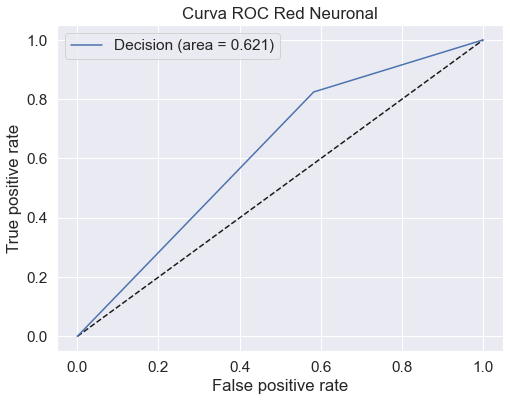

In [1404]:
y_pred = h.argmax(axis = 1)

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)

auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(figsize=(8,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Decision (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Curva ROC Red Neuronal')
plt.legend(loc='best')
plt.show()

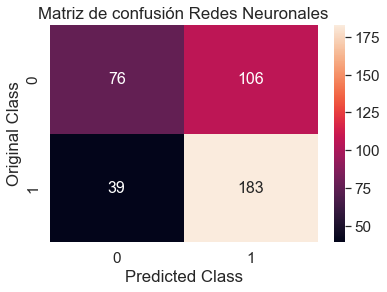

In [1405]:
plt.figure(figsize=(6,4))
df_ = pd.DataFrame(confusion_matrix(y_test,y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_, annot=True,annot_kws={"size": 16}, fmt='g')
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.title('Matriz de confusión Redes Neuronales')
plt.show()

## 6. Support Vector Machine

### 6.1 SVM Kernel Lineal

In [1406]:
C_vec = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
scores = np.zeros(len(C_vec))

acc_train =[]
acc_val = []

bestC = 0.01
bestScore = -1

tiempo_inicial = time()

for c in C_vec:
    aux_kernel = SVC(kernel='linear', C=c)
    aux_kernel.fit(x_train, y_train.ravel())
    score_train =  aux_kernel.score(x_train, y_train)
    acc_train.append(score_train)
    score = aux_kernel.score(x_val, y_val)
    acc_val.append(score)
    if(score > bestScore):
        bestC = c
        bestScore = score

tiempo_final =  time()
tiempo_SVM_lineal = tiempo_final - tiempo_inicial
print("Best score: ", bestScore)
print("Best C:", bestC)
print("Tiempo entrenamiento SVM: {} segundos".format(tiempo_SVM_lineal))


Best score:  0.6806930693069307
Best C: 0.1
Tiempo entrenamiento SVM: 2.926500082015991 segundos


In [1407]:
aux_kernel = SVC(kernel = 'linear', C = bestC)
aux_kernel.fit(x_train, y_train.ravel())
acc_test_SVM_lineal =  aux_kernel.score(x_test, y_test)*100
print('La precisión del test es {} % '.format(acc_test_SVM_lineal))

La precisión del test es 64.85148514851485 % 


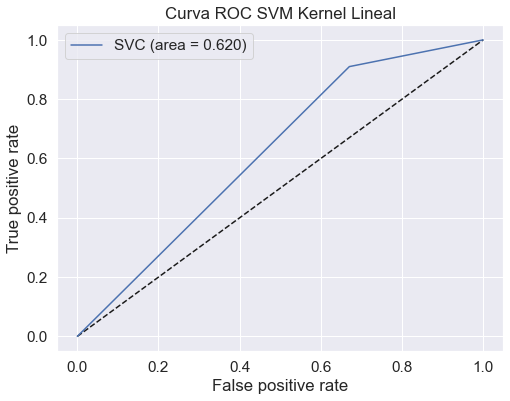

In [1408]:
y_pred= aux_kernel.predict(x_test).ravel()

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)

auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(figsize=(8,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='SVC (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Curva ROC SVM Kernel Lineal')
plt.legend(loc='best')
plt.show()

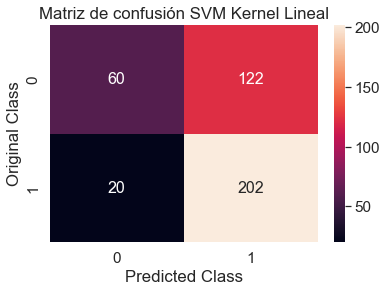

In [1409]:
plt.figure(figsize=(6,4))
df_ = pd.DataFrame(confusion_matrix(y_test,y_pred), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_, annot=True,annot_kws={"size": 16}, fmt='g')
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.title('Matriz de confusión SVM Kernel Lineal')
plt.show()

### 6.2 SVM Kernel Gaussiano

In [1410]:
C_vec = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
sigma_vec = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
scores = np.zeros((len(C_vec), len(sigma_vec)))

acc_train =[]
acc_val = []

bestC = 0.01
bestSigma = 0.01
bestScore = -1

tiempo_inicial = time()

for c in C_vec:
    for sigma in sigma_vec:
        gamma = 1/(2*sigma **2)
        aux_kernel = SVC(C = c, kernel = 'rbf', gamma = gamma)
        aux_kernel.fit(x_train, y_train.ravel())
        score_train =  aux_kernel.score(x_train, y_train)
        acc_train.append(score_train)
        score = aux_kernel.score(x_val, y_val)
        acc_val.append(score)
        if(score > bestScore):
            bestC = c
            bestSigma = sigma
            bestScore = score

tiempo_final =  time()
tiempo_SVM_Gauss = tiempo_final - tiempo_inicial
print("Best score: ", bestScore)
print("Best sigma: ", bestSigma)
print("Best C:", bestC)
print("Tiempo entrenamiento SVM: {} segundos".format(tiempo_SVM_Gauss))


Best score:  0.6881188118811881
Best sigma:  10
Best C: 30
Tiempo entrenamiento SVM: 26.412577867507935 segundos


In [1411]:
gamma = 1/(2*bestSigma **2)
aux_kernel = SVC(C = bestC, kernel = 'rbf', gamma = gamma)
aux_kernel.fit(x_train, y_train.ravel())
acc_test_SVM_Gauss =  aux_kernel.score(x_test, y_test)*100
print('La precisión del test es {} % '.format(acc_test_SVM_Gauss))

La precisión del test es 65.34653465346535 % 


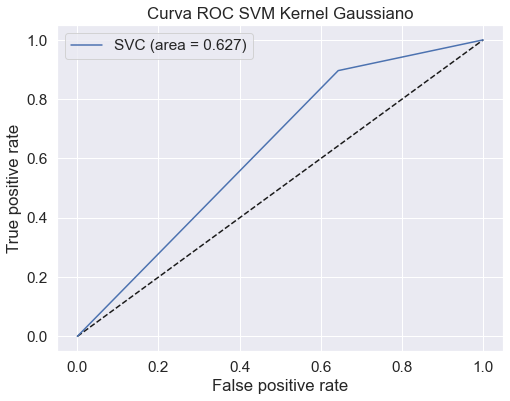

In [1412]:
y_pred= aux_kernel.predict(x_test).ravel()

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)

auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(figsize=(8,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='SVC (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Curva ROC SVM Kernel Gaussiano')
plt.legend(loc='best')
plt.show()

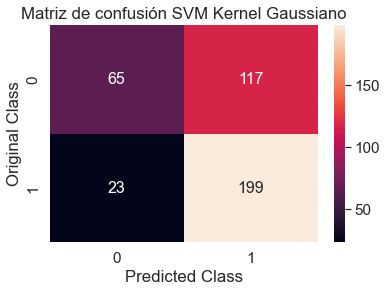

In [1413]:
plt.figure(figsize=(6,4))
df_ = pd.DataFrame(confusion_matrix(y_test,y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_, annot=True,annot_kws={"size": 16}, fmt='g')
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.title('Matriz de confusión SVM Kernel Gaussiano')
plt.show()

## 7. Comparación

In [1414]:
models = pd.DataFrame({
    'Model': ['Regresión Logística Lineal', 'Redes neuronales', 'SVM Lineal', 'SVM Gaussiana'],
    'Score': [ acc_test_Logistic_Linear, acc_test_NN, acc_test_SVM_lineal, acc_test_SVM_Gauss],  
    'seconds': [tiempo_logistic_linear, tiempo_NN, tiempo_SVM_lineal, tiempo_SVM_Gauss]
})

models.sort_values(by = 'Score', ascending = False)

,Model,Score,seconds
3,SVM Gaussiana,65.346535,26.412578
2,SVM Lineal,64.851485,2.926500
1,Redes neuronales,64.108911,27.748234
0,Regresión Logística Lineal,63.118812,0.395915


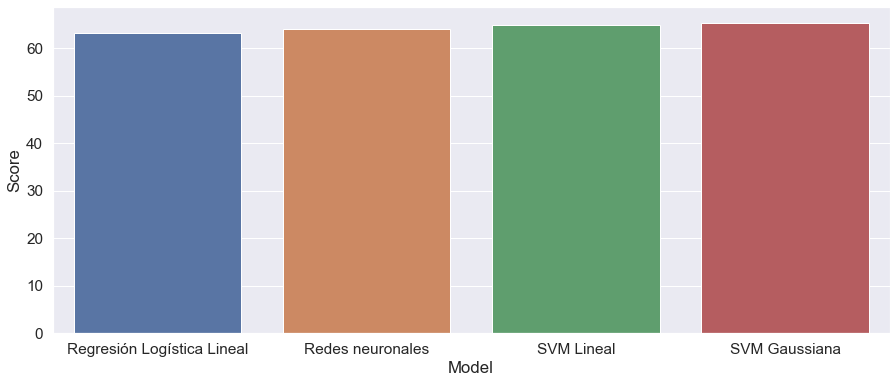

In [1415]:
plt.figure(figsize=(15,6))
sns.barplot(x='Model',y='Score',data=models)
plt.show()

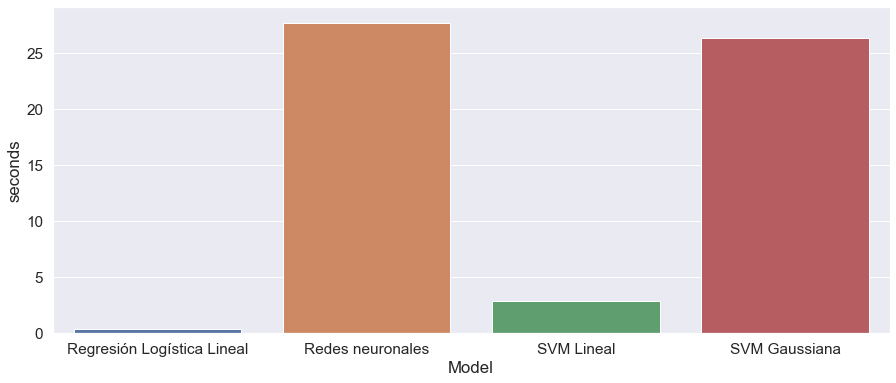

In [1416]:
plt.figure(figsize=(15,6))
sns.barplot(x='Model',y='seconds',data=models)
plt.show()

## 8. Conclusiones

Detalladas en la memoria del proyecto